# Notebook 3) Gender Pay Gap Inference

This notebook builds the statistical backbone of the EquityLens project.

Here we apply a simplified **Blau & Kahn–style decomposition** to understand the gender pay gap: it separates the it into (1) what is due to job characteristics and (2) what remains even after controlling for those characteristics.

- **Model A**: Explains wages using only job-related factors (education, experience, occupation, industry, hours, union status, etc.).  
  - This shows **how much** of the pay gap is due to men and women working in different jobs or having different job characteristics.

- **Model B**: Add gender on top of the same controls.  
  - The coefficient on `female` shows **how much** gap remains when men and women are compared within the same job factors.

We use OLS to understand how job factors (and later gender) shape log wages.

Steps:
- Build **Model A** (job controls only)
- Build **Model B** (job controls + gender)
- Convert the gender coefficient into an **adjusted wage gap (%)
- Measure how much gender improves model fit (ΔR²)
- Run residual checks and a Ridge stability test
- Save clean artifacts for the audit tool

## 1) Importing Libraries

In [17]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

## 2) Loading cohort from SQL and Overview

In [18]:
db_path = "../data/sql_cps_database.db"

conn =sqlite3.connect(db_path)

df = pd.read_sql("SELECT * FROM vw_model_cohort", conn)
conn.close()

df.head()

,year,lnrwg,uhrswork,annhrs,sex,age,educ99,ba,adv,potexp,...,nondurables,retailtrade,wholesaletrade,transport_ind,Utilities,Communications,SocArtOther,hotelsrestaurants,Agriculture,miningconstruction
0,2009,2.155841,40,2080,1,28,10.0,0,0,10,...,0,0,0,0,0,0,0,1,0,0
1,1999,3.245675,40,2080,1,37,11.0,0,0,18,...,0,0,0,0,0,0,0,0,0,0
2,2007,2.141558,80,4160,1,44,15.0,1,0,22,...,0,0,0,0,0,0,0,0,0,0
3,1999,2.909203,40,2080,1,41,10.0,0,0,23,...,0,0,0,1,0,0,0,0,0,0
4,2011,3.472325,40,2080,1,55,10.0,0,0,37,...,0,0,0,0,0,0,0,0,0,0


The dataset comes from the curated SQL view `vw_model_cohort` created in Notebook 2.  
This view already filters valid workers and produces a clean and modeling ready cohort, so the dataframe loaded here is the exact population used for inference.

## 3) Define target and feature columns

In [19]:
target_col = "lnrwg"

excluded_cols = ["lnrwg", "year", "sex"]

feature_cols = [x for x in df.columns if x not in excluded_cols]

X = df[feature_cols]
y = df[target_col]

## 4) Tain/Test Split by Year

In [20]:
latest_year = df["year"].max()
print("Latest year in cohort:", latest_year)

df_train = df[df["year"] < latest_year]

df_test = df[df["year"] == latest_year]

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)


Latest year in cohort: 2013
Train shape: (174458, 52)
Test shape: (46391, 52)


In [21]:
X_train = df_train[feature_cols]
y_train = df_train[target_col]

X_test = df_test[feature_cols]
y_test = df_test[target_col]

## 5) One-hot encode categorical variables for OLS

In [22]:
X_train_ols = pd.get_dummies(X_train, drop_first=True)
X_test_ols  = pd.get_dummies(X_test, drop_first=True)

X_test_ols = X_test_ols.reindex(columns=X_train_ols.columns, fill_value=0)

X_train_ols = sm.add_constant(X_train_ols)
X_test_ols  = sm.add_constant(X_test_ols)

X_train_ols.shape, X_test_ols.shape

((174458, 50), (46391, 50))

Categorical variables are one-hot encoded so that OLS can estimate a coefficient for each job category, industry and education level. 
The test set is reindexed to match the training set's matrix and the add_constant() step includes an intercept term, for an interpretable output.

# 6) Model A: Job Factors Only

Model A estimates how job related factors explain wages without factoring in `gender`. This is the **baseline model** that will be compared against model B to measure exactly how much gender contributes beyond these factors.

In [23]:
X_train_A = X_train_ols.copy()
X_test_A = X_test_ols.copy()

modelA = sm.OLS(y_train, X_train_A).fit()
display(modelA.summary())

r2_A = modelA.rsquared
print("Model A R²:", r2_A)

y_predA_test = modelA.predict(X_test_A)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnrwg   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     2515.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:36:58   Log-Likelihood:            -1.1446e+05
No. Observations:              174458   AIC:                         2.290e+05
Df Residuals:                  174410   BIC:                         2.295e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.5845      0.045     35.546      0.000       1.497       1.672
uhrswork                   -0.0184      0.005     -3.674      0.000      -0.028      -0.009
annhrs                      0.0003   9.66e-05      3.272      0.001       0.000       0.001
age                         0.0063      0.003      2.204      0.028       0.001       0.012
educ99                      0.0507      0.001     48.009      0.000       0.049       0.053
ba                          0.1002      0.007     13.722      0.000       0.086       0.115
adv                         0.2369      0.012     19.600      0.000       0.213       0.261
potexp                      0.0219      0.003      7.566      0.000       0.016       0.028
potexp2                    -0.0004      1e-05    -44.530      0.000      -0.000      -0.000
classwkr                   -0.0014      0.001     -1.893      0.058      -0.003     4.9e-05
union                       0.0138      0.002      5.950      0.000       0.009       0.018
ft                          0.1939      0.005     38.658      0.000       0.184       0.204
manager                     0.3121      0.004     73.753      0.000       0.304       0.320
business                    0.1667      0.007     22.258      0.000       0.152       0.181
financialop                 0.1858      0.007     24.937      0.000       0.171       0.200
computer                    0.3728      0.007     54.241      0.000       0.359       0.386
architect                   0.3096      0.007     41.679      0.000       0.295       0.324
scientist                   0.1591      0.010     15.576      0.000       0.139       0.179
socialworker               -0.0965      0.008    -11.424      0.000      -0.113      -0.080
postseceduc                 0.0833      0.012      6.862      0.000       0.059       0.107
legaleduc                  -0.0673      0.006    -10.535      0.000      -0.080      -0.055
artist                      0.0874      0.010      8.960      0.000       0.068       0.107
lawyerphysician             0.5522      0.011     51.771      0.000       0.531       0.573
healthcare                  0.2562      0.006     40.594      0.000       0.244       0.269
healthsupport              -0.2096      0.008    -25.939      0.000      -0.225      -0.194
protective                  0.1325      0.008     16.681      0.000       0.117       0.148
foodcare                   -0.1950      0.006    -31.897      0.000      -0.207      -0.183
building                   -0.2270      0.007    -34.135      0.000      -0.240      -0.214
sales                       0.0767      0.005     15.228      0.000       0.067       0.087
officeadmin                -0.0917      0.004    -23.277      0.000      -0.099      -0.084
farmer                     -0.2055      0.019  

Model A R²: 0.40395841462892323


#### **Key Points:**

This model uses only job related variables (hours, education, experience, occupation, industry, etc.) to explain log wages, without including gender. 
It explains about 40% of the variation in log wages (R² ≈ 0.40).  
Most variables are statistically significant (very low p-values), and their effects make sense: higher education and skilled occupations increase wages, while lower paid sectors like food service or cleaning roles reduce wages. This shows a credible baseline that I will next compare to a model that also includes gender.

### 6.1) Residuals (Test year)

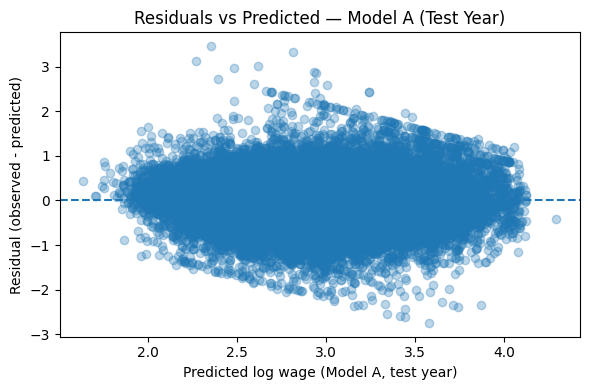

In [24]:
residA_test = y_test - y_predA_test

plt.figure(figsize=(6, 4))
plt.scatter(y_predA_test, residA_test, alpha=0.3)
plt.axhline(0, linestyle="--")

plt.xlabel("Predicted log wage (Model A, test year)")
plt.ylabel("Residual (observed - predicted)")
plt.title("Residuals vs Predicted — Model A (Test Year)")
plt.tight_layout()
plt.show()

#### Key Points:

This plot checks whether Model A behaves reasonably on the most recent year.  
The residuals are roughly centred around zero across the prediction range, with no strong curve or pattern. Therefore the model is not perfect, but it is good enough as a baseline for wages before adding gender in Model B.

# 7) Model B) Job Factors + Gender

Model B adds gender to the same job controls and therefore quantifies the adjusted gender pay gap, i.e.:

`The difference in pay between men and women holding all job factors constant.`

In [25]:
X_train_ols_B = X_train_ols.copy()
X_test_ols_B  = X_test_ols.copy()

X_train_ols_B["female"] = (df_train["sex"] == 2).astype(int)
X_test_ols_B["female"]  = (df_test["sex"] == 2).astype(int)

modelB = sm.OLS(y_train, X_train_ols_B).fit()
display(modelB.summary())

r2_B = modelB.rsquared
print("Model B R²:", r2_B)

y_predB_test = modelB.predict(X_test_ols_B)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnrwg   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     2681.
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:37:00   Log-Likelihood:            -1.1140e+05
No. Observations:              174458   AIC:                         2.229e+05
Df Residuals:                  174409   BIC:                         2.234e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.7914      0.044     40.827      0.000       1.705       1.877
uhrswork                   -0.0190      0.005     -3.856      0.000      -0.029      -0.009
annhrs                      0.0003   9.49e-05      3.106      0.002       0.000       0.000
age                         0.0037      0.003      1.309      0.190      -0.002       0.009
educ99                      0.0505      0.001     48.723      0.000       0.048       0.053
ba                          0.0954      0.007     13.292      0.000       0.081       0.109
adv                         0.2309      0.012     19.442      0.000       0.208       0.254
potexp                      0.0247      0.003      8.676      0.000       0.019       0.030
potexp2                    -0.0004   9.84e-06    -45.560      0.000      -0.000      -0.000
classwkr                   -0.0014      0.001     -1.979      0.048      -0.003   -1.35e-05
union                       0.0136      0.002      5.981      0.000       0.009       0.018
ft                          0.1770      0.005     35.888      0.000       0.167       0.187
manager                     0.3256      0.004     78.230      0.000       0.317       0.334
business                    0.2084      0.007     28.247      0.000       0.194       0.223
financialop                 0.2277      0.007     31.030      0.000       0.213       0.242
computer                    0.3540      0.007     52.390      0.000       0.341       0.367
architect                   0.2711      0.007     37.063      0.000       0.257       0.285
scientist                   0.1666      0.010     16.601      0.000       0.147       0.186
socialworker               -0.0597      0.008     -7.180      0.000      -0.076      -0.043
postseceduc                 0.0800      0.012      6.709      0.000       0.057       0.103
legaleduc                  -0.0033      0.006     -0.519      0.604      -0.016       0.009
artist                      0.0995      0.010     10.372      0.000       0.081       0.118
lawyerphysician             0.5585      0.010     53.281      0.000       0.538       0.579
healthcare                  0.3127      0.006     50.093      0.000       0.300       0.325
healthsupport              -0.1461      0.008    -18.310      0.000      -0.162      -0.130
protective                  0.0873      0.008     11.159      0.000       0.072       0.103
foodcare                   -0.1644      0.006    -27.305      0.000      -0.176      -0.153
building                   -0.2362      0.007    -36.143      0.000      -0.249      -0.223
sales                       0.0971      0.005     19.594      0.000       0.087       0.107
officeadmin                -0.0237      0.004     -5.976      0.000      -0.031      -0.016
farmer                     -0.2223      0.019  

Model B R²: 0.42453528815374486


### 7.1) Gender Coefficient and R²  Variation

In [26]:
gender_coef = modelB.params["female"]
gap_pct = (np.exp(gender_coef) - 1) * 100

print("Gender coefficient:", gender_coef)
print("Adjusted gender pay gap (%):", gap_pct)

r2_B = modelB.rsquared

var_r2 = r2_B - r2_A

print("R² Model B:", r2_B)
print("ΔR² (explained by gender):", var_r2)

Gender coefficient: -0.20969105166459978
Adjusted gender pay gap (%): -18.91652866875768
R² Model B: 0.42453528815374486
ΔR² (explained by gender): 0.020576873524821626


#### Key Points:

Model B adds a single variable: a **female** indicator, which isolates the gender pay gap. This addition raises R² from 0.404 to 0.425, so gender explains an additional 2.1 percentage points of wage variation beyond job factors.

The coefficient on *female* is **−0.2097** and highly significant (p < 0.001).

# 8) Ridge Stability Check

In [27]:
ridge = Ridge(alpha=1.0)

X_train_ridge = X_train_ols_B.drop(columns="const")

scaler = StandardScaler()
Xr_train_scaled = scaler.fit_transform(X_train_ridge)

ridge.fit(Xr_train_scaled, y_train)

female_coef = list(X_train_ridge.columns).index("female")
female_coef_scaled = ridge.coef_[female_coef]

# undo the scaling
female_effect = female_coef_scaled / scaler.scale_[female_coef]

ridge_gap_pct = (np.exp(female_effect) - 1) * 100
print("Ridge female coefficient (logwage):", female_effect)
print("Ridge adjusted gap (%):", ridge_gap_pct)

Ridge female coefficient (logwage): -0.20968851745587438
Ridge adjusted gap (%): -18.916323186056783


#### Key Points:

After standardising and fitting a Ridge regression, the estimated female effect on log wages is **–0.2097**, which corresponds to an **adjusted wage gap of –18.9%**.

This is essentially identical to the OLS result.  
Therefore, the adjusted gender wage gap is **not driven by multicollinearity or any single dummy**.  
It reflects a persistent pattern in the market data.


# 9) Fairness Check

In [28]:
residA_test = y_test - y_predA_test
residB_test = y_test - y_predB_test

df_fair = pd.DataFrame({
    "sex": df_test["sex"],
    "resid_A": residA_test,
    "abs_resid_A": np.abs(residA_test),
    "resid_B": residB_test,
    "abs_resid_B": np.abs(residB_test)
})

fair_summary = df_fair.groupby("sex").agg(
    mean_residual_A=("resid_A", "mean"),
    mean_abs_error_A=("abs_resid_A", "mean"),
    mean_residual_B=("resid_B", "mean"),
    mean_abs_error_B=("abs_resid_B", "mean"),
    count=("resid_A", "count"),
)

fair_summary

,mean_residual_A,mean_abs_error_A,mean_residual_B,mean_abs_error_B,count
sex,,,,,
1,0.065324,0.371391,-0.006023,0.367220,24109
2,-0.071493,0.355377,0.003556,0.348712,22282


#### Key Points:

The model’s prediction accuracy is very similar for men and women. Mean absolute errors for both Model A and Model B are around 0.35–0.37 in log-wage units, so the model does not systematically fit one gender better.

The residuals flip between models:

    Model A (gender-blind):

        - Overpredicts for men (+0.065)

        - Underpredicts for women (–0.071)

    Model B (gender-explicit):

        - Residuals move closer to zero for both groups

        - The small remaining biases (–0.006 for men, +0.004 for women) are very small.

Overall:
The wage models perform similarly for men and women, and adding gender mostly removes the systematic errors rather than creating new imbalances.


# 10) Saving Artifacts

In [29]:
artifacts = {
    "model_A_r2": float(r2_A),
    "model_B_r2": float(r2_B),
    "delta_r2": float(var_r2),
    "gender_coef_female": float(gender_coef),
    "gender_gap_pct": float(gap_pct),
    "ridge_gender_coef": float(female_effect),
    "ridge_gender_gap_pct": float(ridge_gap_pct),
    "fairness": {
        "sex_1": {
            "mean_residual_A": float(fair_summary.loc[1, "mean_residual_A"]),
            "mean_abs_error_A": float(fair_summary.loc[1, "mean_abs_error_A"]),
            "mean_residual_B": float(fair_summary.loc[1, "mean_residual_B"]),
            "mean_abs_error_B": float(fair_summary.loc[1, "mean_abs_error_B"]),
            "count": int(fair_summary.loc[1, "count"])
        },
        "sex_2": {
            "mean_residual_A": float(fair_summary.loc[2, "mean_residual_A"]),
            "mean_abs_error_A": float(fair_summary.loc[2, "mean_abs_error_A"]),
            "mean_residual_B": float(fair_summary.loc[2, "mean_residual_B"]),
            "mean_abs_error_B": float(fair_summary.loc[2, "mean_abs_error_B"]),
            "count": int(fair_summary.loc[2, "count"])
        }
    }
}

Path("../artifacts").mkdir(exist_ok=True)
with open("../artifacts/inference_metrics.json", "w") as f:
    json.dump(artifacts, f, indent=2)

# 11) Summary

This notebook used OLS to measure the adjusted gender pay gap in the CPS cohort.

- Model A (job factors only) explains roughly 40% of wage variation and establishes the baseline.
- Model B (job factors + gender) finds an adjusted gap of about 19% lower wages for women, with gender increasing R² by roughly 2 percentage points.
- A Ridge check shows that the gender effect is not driven by unstable or highly collinear variables.
- Fairness diagnostics showed that prediction errors are very similar for men and women in the chosen Ridge model, with only small residual biases in opposite directions.

All key metrics are saved in ```artifacts/inference_metrics.json```.
In Notebook 4, I will build the machine-learning wage benchmark model used by the Streamlit app to estimate gender-blind wages for uploaded company data.

### End of Notebook 3